#Summary of the notebook
####The notebook is divided into the several sections, and will be keep updated during my internship with a further study of a text classification.

The purpose of this notebook is to perform a text classification of financial news article with target value of Sentiment ($positive, neutral, negative$) and Importance ($important, normal, negligible$) regarding the firm it covers. With two parameters, our team will select 15-20 firms that are worth spotlight of a day and publish a report about the firm automatically.

In this notebook, I have implemented text classification using deep learning method, and have achieved $76$% accuracy on 5-fold cv but our team focuses on what we defined as critical error.

Let $S_i,r$ be the actual sentiment of the article labeled by analyst, and $S_i,p$ be the predicted sentiment of the article by the model. Then, the critical error is defined as below:
* $Critical\enspace Error = \frac{\sum_{i=1}^{n} \mathbb{1}_\{S_i,r = positive, S_i,p\ = negative\} +  \mathbb{1}_\{S_i,r = negative, S_i,p\ = positive\}}{Total\enspace number\enspace of\enspace article}$

The sentiment can be changed to importance with $positive = importance$ and $negative = negligible$. Since the evaluation of the article might be different by analysts' perspectives, we do not like to publish a report with news tagged as negative but some view as positive. We want such report to be published as neutral. Therefore, we care more about the critical error that we have defined. 

Currently, the section is divied into following:
* Data speculation
* BERT Model with a Linear classifier on top
* FinBERT Model with a Linear classifier on top
* BERT Model with Kim CNN classifier on top
  * Kim CNN is from [Yoon Kim's article](https://arxiv.org/abs/1408.5882) on sentence classification.

After implementing a few BERT model for the text classification on the financial text domain, I have felt that BERT might not be the holy grail on the financial domain. 

Further approach might be RNN or LSTM on top of the BERT or mining associative rule on the neural network environment. 

In [ ]:
#huggingface library installation
#!pip install transformers

In [2]:
import numpy as np
import pandas as pd

import os
from transformers import BertForTokenClassification, AdamW, BertConfig, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import random
import numpy as np
import transformers
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from torch.autograd import Variable
import time
import datetime
from platform import python_version
import sklearn
import torch

In [3]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)

python version==3.6.9
pandas==1.0.5
numpy==1.18.5
torch==1.5.1+cu101
sklearn==0.22.2.post1
transformers==3.0.2


In [4]:
#Using Colab GPU for training
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [5]:
#To confirm that we are using GPU for the training later
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# About the Notebook

For the code implementation of fine-tuning the BERT model, I have referred mostly to the [Tutorial: Fine tuning BERT for Sentiment analysis](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/), [BERT Fine-Tuning tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), and [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) from huggingface library.

# 1. Data Set

The original news article data sets are provided by CIMS to Korea Investment. Then, the sentiments and scores of articles are labeled by the Analysts or research assistants in Research center of Korea Investment. 0,1,2 means negative, neutral, positivie respectively for the sentiment score and 0,1,2 means, negligible, normal, important respectively for the score part. 

The summary_v1, summary_v2 columns are the summarization by the distilbert-base-uncased summarizer uploaded in the huggingface library. summary_v1 is a summarization of text column, summary_v2 is a summarization of the summary_v1 column


## 1.1 Load Data

In [6]:
#Data import
import pandas as pd

df = pd.read_excel('/content/CIMS_industrytagged_sum2.xlsx')
df = df.iloc[:,1:]
df.head()

,unnamed: 0,date,source,title,text,stock_name,url,sentiment,importance,importance_score,summary_v1,summary_v2
0,0,20200601,CIMS,Microsoft Accepting Bitcoin Again After A Brie...,Microsoft has resumed receiving the bitcoins a...,Microsoft Corp.,http://render.daumsoft.com/cims_redir/?action=...,neutral,neutral,1.065,Microsoft has resumed receiving the bitcoins a...,Microsoft has resumed receiving the bitcoins a...
1,1,20200601,CIMS,Bankrupt Hertz Rings BlackRock’s Stock Market ...,"May 25, 2020 8:13 AM UTC Bankrupt Hertz Ring...",BlackRock,http://render.daumsoft.com/cims_redir/?action=...,neutral,neutral,1.105,"May 25, 2020 8:13 AM UTC Bankrupt Hertz Ring...","May 25, 2020 8:13 AM UTC Bankrupt Hertz Ring..."
2,2,20200601,CIMS,Mark Zuckerberg Leaps Warren Buffett on Rich L...,"May 27, 2020 2:15 PM UTC Mark Zuckerberg Lea...","""Facebook, Inc.""",http://render.daumsoft.com/cims_redir/?action=...,neutral,neutral,1.197,"May 27, 2020 2:15 PM UTC Mark Zuckerberg Lea...","May 27, 2020 2:15 PM UTC Mark Zuckerberg Lea..."
3,3,20200601,CIMS,Tesla Needs Democrats to Break Up Big Tech or ...,"May 31, 2020 11:00 PM UTC Tesla Needs Democr...",Amazon.com Inc.,http://render.daumsoft.com/cims_redir/?action=...,neutral,neutral,1.089,"May 31, 2020 11:00 PM UTC Tesla Needs Democr...","May 31, 2020 11:00 PM UTC Tesla Needs Democr..."
4,4,20200601,CIMS,Apple & Google’s Thirst For Covid-19 Data Is B...,"May 6, 2020 2:46 PM Apple & Google’s Thirst ...","Alphabet Inc Class A , Alphabet Inc Class C , ...",http://render.daumsoft.com/cims_redir/?action=...,neutral,negative,0.065,"May 6, 2020 2:46 PM Apple & Google’s Thirst ...","May 6, 2020 2:46 PM Apple & Google’s Thirst ..."


In [7]:
#Remove the articles with flawed summary
print(len(df))
idx_to_remove = []
for i in range(len(df)):
  if type(df['summary_v1'][i]) == float:
    idx_to_remove.append(i)

df = df.iloc[list(set(df.index) - set(idx_to_remove))]
df.index = np.arange(0, len(df))
print(len(df))

idx_to_remove = []
for i in range(len(df)):
  if type(df['summary_v2'][i]) == float:
    idx_to_remove.append(i)

df = df.iloc[list(set(df.index) - set(idx_to_remove))]
df.index = np.arange(0, len(df))
print(len(df))

1394
1389
1388


In [8]:
#Convert the sentiment from negative, neutral, positive to 0,1,2
for i in range(len(df)):
  if df.loc[i,'sentiment'] == 'negative':
    df.loc[i,'sentiment'] = 0
  elif df.loc[i,'sentiment'] == 'neutral':
    df.loc[i,'sentiment'] = 1
  elif df.loc[i,'sentiment'] == 'positive':
    df.loc[i,'sentiment'] = 2
  if df.loc[i, 'importance'] == 'negative':
    df.loc[i, 'importance'] = 0
  elif df.loc[i, 'importance'] == 'neutral':
    df.loc[i, 'importance'] = 1
  elif df.loc[i, 'importance'] == 'positive':
    df.loc[i, 'importance'] = 2

In [9]:
#Distribution in the length of summary
length = [len(df['summary_v1'][i]) for i in range(len(df))]
df_stat = pd.DataFrame(length)
df_stat.describe()

,0
count,1388.000000
mean,555.306196
std,273.813346
min,44.000000
25%,343.000000
50%,536.000000
75%,759.000000
max,1667.000000


In [10]:
#Distribution in the length of summary
length = [len(df['summary_v2'][i]) for i in range(len(df))]
df_stat = pd.DataFrame(length)
df_stat.describe()

,0
count,1388.000000
mean,289.553314
std,149.382973
min,41.000000
25%,174.000000
50%,261.000000
75%,384.250000
max,886.000000


In [11]:
#Distribution in the length of title
length = [len(df['title'][i]) for i in range(len(df))]
df_stat = pd.DataFrame(length)
df_stat.describe()

,0
count,1388.000000
mean,76.207493
std,32.260814
min,6.000000
25%,55.000000
50%,68.500000
75%,89.000000
max,224.000000


In [12]:
len(df[df['sentiment'] == 0])

314

In [ ]:
#For the UnderSampling purpose, if one want to perform random sampling
import random
sentiment_num = [len(df[df['sentiment'] == 0]), len(df[df['sentiment'] == 1]),len(df[df['sentiment'] == 2])] 
importance_num = [len(df[df['importance'] == 0]), len(df[df['importance'] == 1]),len(df[df['importance'] == 2])]

sentiment_list = {0,1,2}
importance_list = {0,1,2}

sentiment_min_idx, importance_min_idx = np.argmin(sentiment_num), np.argmin(importance_num)

sentiment_list = list(sentiment_list - {sentiment_min_idx})
importance_list = list(importance_list - {importance_min_idx}) 

sentiment_index_to_be_removed = random.sample(list(df[df['sentiment'] == sentiment_list[0]].index), sentiment_num[sentiment_list[0]] - sentiment_num[sentiment_min_idx])
sentiment_index_to_be_removed += random.sample(list(df[df['sentiment'] == sentiment_list[1]].index), sentiment_num[sentiment_list[1]] - sentiment_num[sentiment_min_idx])

importance_index_to_be_removed = random.sample(list(df[df['importance'] == importance_list[0]].index), importance_num[importance_list[0]] - importance_num[importance_min_idx])
importance_index_to_be_removed += random.sample(list(df[df['importance'] == importance_list[1]].index), importance_num[importance_list[1]] - importance_num[importance_min_idx])

In [ ]:
#Sentiment UnderSampling
df = df.iloc[list(set(df.index) - set(sentiment_index_to_be_removed))]
df.index = np.arange(0, len(df))

In [ ]:
#Importance UnderSampling
df = df.iloc[list(set(df.index) - set(importance_index_to_be_removed))]
df.index = np.arange(0, len(df))

## 1.2 Data Speculation and preprocess

In [13]:
'''
Sentiment Analysis using only title of the articles
'''
from sklearn.model_selection import train_test_split

X, y1, y2 = df['title'], df['sentiment'], df['importance']
y1_values, y2_values = y1.values, y2.values

In [14]:
#Create another column named title_summary which is just concatenation of title and summary
#Distribution of title_summary in number of tokens
df['title_summary'] = df['title'] + ' ' + df['summary_v2']

title_summary_len = [len(df['summary_v2'][i].split(' ')) for i in range(len(df))]
df_stat = pd.DataFrame(title_summary_len)
df_stat.describe()

,0
count,1388.000000
mean,46.452450
std,23.529697
min,6.000000
25%,29.000000
50%,43.000000
75%,61.000000
max,142.000000


In [15]:
#Stat on word counts of title
title_summary_len = [len(df['title_summary'][i].split(' ')) for i in range(len(df))]
#summary_v1_len = [len(df['summary_v1'][i]) for i in range(len(df))]
df_stat = pd.DataFrame(title_summary_len)
df_stat.describe()

,0
count,1388.000000
mean,58.257205
std,24.775229
min,11.000000
25%,40.000000
50%,55.000000
75%,74.000000
max,160.000000


In [22]:
'''
Sentiment Analysis using title and summary of the articles
'''

X, y1, y2 = df['title_summary'], df['sentiment'], df['importance']
y1_values, y2_values = y1.values, y2.values

In [16]:
X, y1= df['title_summary'],  df['importance']
y1_values = y1.values

Below is the distribution of labels from the dataset. Since one can inspect that the importance data is highly imbalanced. However, as the label distribution indicates that even on a larger sample, the distribution is similar. Therefore, one do not have to perform undersampling to avoid the over fit. 


In [23]:
label_count_1, label_count_2 = [0,0,0], [0,0,0]
for i in range(len(y1)):
  label_count_1[y1_values[i]] += 1
  label_count_2[y2_values[i]] += 1

In [24]:
print(label_count_1, label_count_2)

[314, 714, 360] [406, 603, 379]


In [25]:
sum(label_count_1) == len(y1)

True

In [26]:
print([round(label_count_1[i]/sum(label_count_1),3) for i in range(len(label_count_1))], [round(label_count_2[i]/sum(label_count_2),3) for i in range(len(label_count_2))])

[0.226, 0.514, 0.259] [0.293, 0.434, 0.273]


# 2. Fine-Tune BERT Model

## 2.1 Tokenization

Before we proceed with tokenization just using the BERT tokenizer lets inspect a bit 

In [27]:
from transformers import *

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Print the original sentence.
print(' Original: ', X[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(X[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X[0])))

 Original:  Microsoft Accepting Bitcoin Again After A Brief Halt Over Instability Microsoft has resumed receiving the bitcoins as a payment again after a brief halt. Advertisement   Microsoft is again receiving the Bitcoin payments   It has been reported by Bleeping Computer that Microsoft had suspended the bitcoin transactions, last week.
Tokenized:  ['microsoft', 'accepting', 'bit', '##co', '##in', 'again', 'after', 'a', 'brief', 'halt', 'over', 'instability', 'microsoft', 'has', 'resumed', 'receiving', 'the', 'bit', '##co', '##ins', 'as', 'a', 'payment', 'again', 'after', 'a', 'brief', 'halt', '.', 'advertisement', 'microsoft', 'is', 'again', 'receiving', 'the', 'bit', '##co', '##in', 'payments', 'it', 'has', 'been', 'reported', 'by', 'b', '##lee', '##ping', 'computer', 'that', 'microsoft', 'had', 'suspended', 'the', 'bit', '##co', '##in', 'transactions', ',', 'last', 'week', '.']
Token IDs:  [7513, 10564, 2978, 3597, 2378, 2153, 2044, 1037, 4766, 9190, 2058, 18549, 7513, 2038, 7943

In [28]:
#In order to get the right amount of the padding, we need to know the max length of title+summary or title
max_len = 0
too_big_input = []
len_dist = []
for i in range(len(X)):
  input_ids = tokenizer.encode(X[i], add_special_tokens = True)
  max_len = max(len(input_ids), max_len)
  len_dist.append(len(input_ids))
  if len(input_ids) > 512:
    too_big_input.append(i)

print('Max length of title is ', max_len)
df_stat = pd.DataFrame(len_dist)
df_stat.describe()

Max length of title is  227


,0
count,1388.000000
mean,79.093660
std,32.900933
min,18.000000
25%,54.000000
50%,75.000000
75%,100.000000
max,227.000000


## 2.2 Text Preprocess

In this notebook, I have not used the below function for my text preprocess but I have performed all the text cleaning during the summarization of the article. One can refer to below code for the text preprocess. Furthermore, in my case, the average validation accuracy is 0.05 higher for text without preprocessing as stated below than preprocessed text. Hence, I will not perform the text-preprocess in this case. 

If anyone want to perform the text-preprocess while fine-tuning the BERT model, one can change sent to text_preprocess(sent) in preprocessing_for_bert function

In [29]:
#My choice was between 512 or 256 if X is title + summary
#64 for if X is title only
MAX_LEN = 256

#The below code can be later modified to add the segment_id of setences. 
#However, since the summary + title data outperforms the validation accuracy from finBERT, I will modify this after implement the XLNet classifier

def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask
            truncation = True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

## 2.3 Data Preparation for BERT

Since I will do 5-fold cross validation, the below code will be again implemented when fine-tuning the BERT model, but one can the text data will be converted into tensor forms, then dataset, then will be called by Data Loader, so we can save the memory space.

During the fine-tuning BERT model, we will separate them with train and validation set only.

In [25]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import re

train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

#Data Loader
train_labels = torch.tensor(y1_train.values)
val_labels = torch.tensor(y1_val.values)


batch_size = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

NameError: ignored

## 2.4 Visualize the embedded dataset in manifold space

### 2.4-1 X with title only

In [ ]:
tokenized, am = preprocessing_for_bert(X)

model = BertModel.from_pretrained('bert-base-uncased')

with torch.no_grad():
  encoder_hidden_state = model(tokenized, attention_mask=am)

In [ ]:
from sklearn.manifold import TSNE

X_for_graph = encoder_hidden_state[0][:,0,:].numpy()
X_for_graph = TSNE(n_components = 2, random_state = 42).fit_transform(X_for_graph)
X_for_graph.shape

(1388, 2)

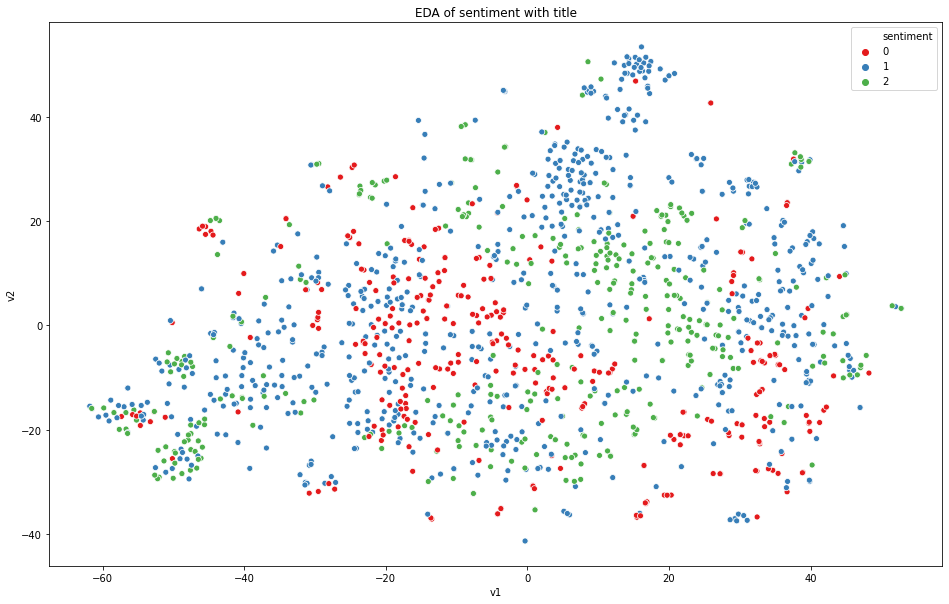

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def creat_plotting_data(data, labels):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["sentiment"] = labels.to_numpy()
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df


plotting_data_embedded = creat_plotting_data(X_for_graph, labels = y1)
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="sentiment", data=plotting_data_embedded, palette="Set1")
ax.set(title = 'EDA of sentiment with title')
plt.show()

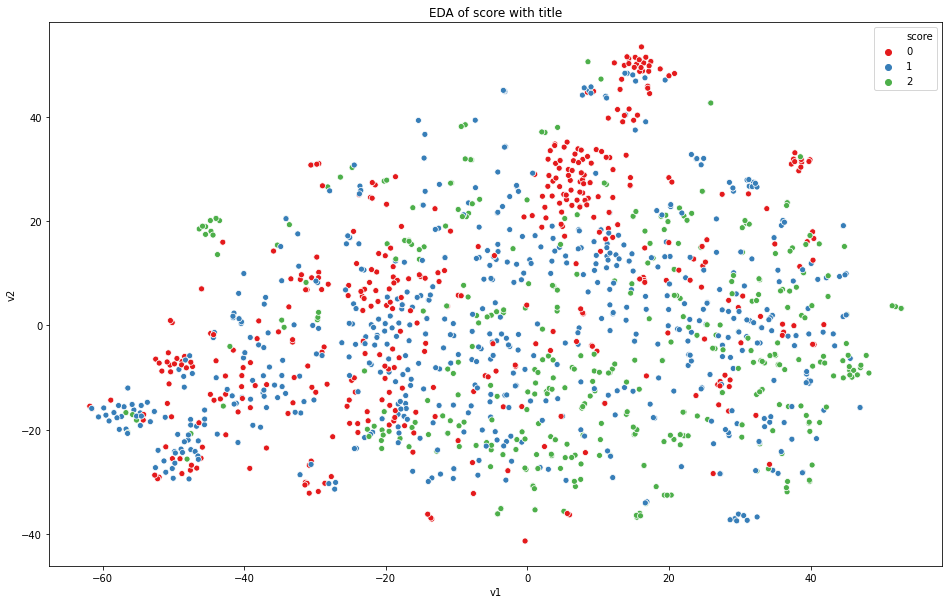

In [ ]:
def creat_plotting_data(data, labels):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["score"] = labels.to_numpy()
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df

plotting_data_embedded = creat_plotting_data(X_for_graph, labels = y2)
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="score", data=plotting_data_embedded, palette="Set1")
ax.set(title = 'EDA of score with title')
plt.show()

### 2.4-2 X with title + summary

Because of the lack of memory space, I will sample only 500 for the visualization

In [ ]:
tokenized, am = preprocessing_for_bert(X[:500])

model = BertModel.from_pretrained('bert-base-uncased')

with torch.no_grad():
  encoder_hidden_state = model(tokenized, attention_mask=am)


from sklearn.manifold import TSNE

X_for_graph = encoder_hidden_state[0][:,0,:].numpy()
X_for_graph = TSNE(n_components = 2, random_state = 42).fit_transform(X_for_graph)
X_for_graph.shape

(500, 2)

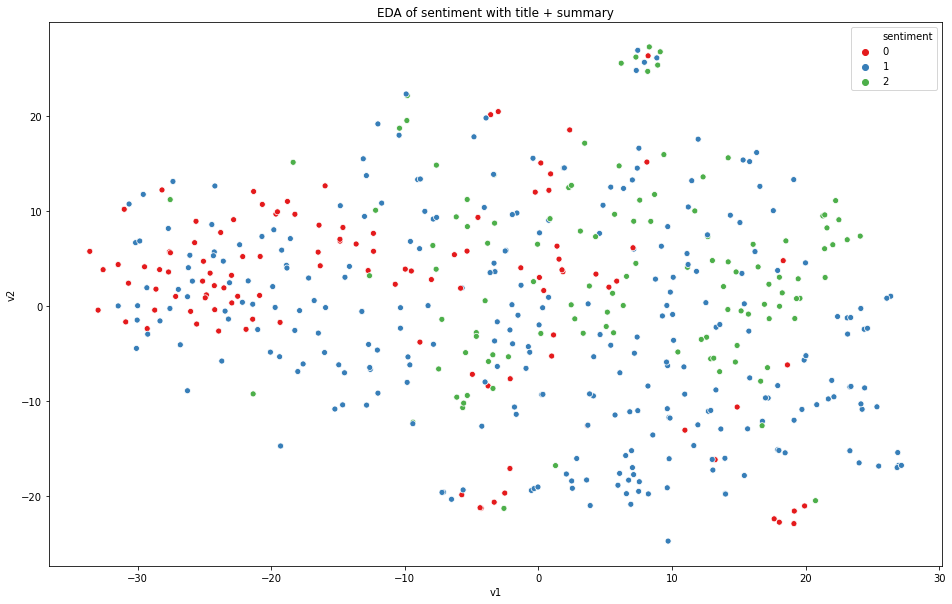

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def creat_plotting_data(data, labels):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["sentiment"] = labels.to_numpy()
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df


plotting_data_embedded = creat_plotting_data(X_for_graph, labels = y1[:500])
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="sentiment", data=plotting_data_embedded, palette="Set1")
ax.set(title = 'EDA of sentiment with title + summary')
plt.show()

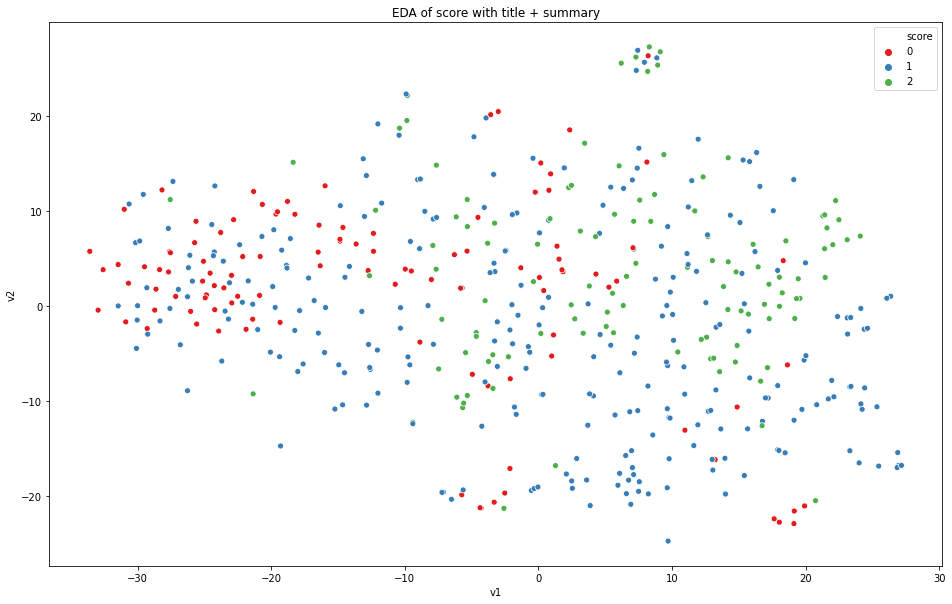

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def creat_plotting_data(data, labels):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["score"] = labels.to_numpy()
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df


plotting_data_embedded = creat_plotting_data(X_for_graph, labels = y1[:500])
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="score", data=plotting_data_embedded, palette="Set1")
ax.set(title = 'EDA of score with title + summary')
plt.show()

## 2.5 Fine Tuning functions

The below code for the functions are for fine-tuning the BERT model. Unlikely, conventional way to change the last (12th layer) to fine-tune in transfer learning, I have added another feed-forward layer for the classification purpose. Since it is easier to just add one more layer to the BERT.

In [30]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 100, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits


CPU times: user 42 µs, sys: 0 ns, total: 42 µs
Wall time: 44.8 µs


In [31]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [34]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    return float(val_loss), float(val_accuracy)
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

## 2.6 Fine Tuning 

According to the [Devlin et al., 2018](https://arxiv.org/abs/1810.04805), the following parameters' range works well across all task.
* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2,3,4

I have tried many different parameters. For X with summary and title, I have no choice but to choose batch size of 16 due to the limitation on memory. Learning rate seems to perform best on 2e-5, and the model seems to overfit after the second epoch. Even though the mean validation accuracy of cross validation is higher with more epoch, but the difference between train loss and validation loss gets larger after the third epoch. In order to avoid the overfit, I will choose the parameter as below:
* Batch size: 16
* Learning Rate: 2e-5
* Number of epochs: 2

In [35]:
from sklearn.model_selection import KFold
#train and val are indices
kf = KFold(n_splits=5, shuffle = True)

batch_size = 16
train_loss = []
val_loss = []
val_accuracy = []

y1 = y1.astype(int)

for train_index, val_index in kf.split(X):
  #Data Preparation
  X_train = X[train_index]
  X_val = X[val_index]
  y1_train = y1[train_index]
  y1_val = y1[val_index]
  
  train_inputs, train_masks = preprocessing_for_bert(X_train)
  val_inputs, val_masks = preprocessing_for_bert(X_val)
  train_labels = torch.tensor(y1_train.values)
  val_labels = torch.tensor(y1_val.values)
  
  #Data Loader Class
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

  val_data = TensorDataset(val_inputs, val_masks, val_labels)
  val_sampler = RandomSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

  #Fine Tune and Evaluation
  set_seed(42)    # Set seed for reproducibility
  bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
  val_loss1, val_accuracy1 = train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)
  
  val_loss.append(val_loss1)
  val_accuracy.append(val_accuracy1)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.002267   |     -      |     -     |   14.95  
   1    |   40    |   0.939498   |     -      |     -     |   14.72  
   1    |   60    |   0.831748   |     -      |     -     |   14.91  
   1    |   69    |   0.791477   |     -      |     -     |   6.13   
----------------------------------------------------------------------
   1    |    -    |   0.908511   |  0.670640  |   72.80   |   55.24  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.687923   |     -      |     -     |   15.03  
   2    |   40    |   0.584788   |     -      |     -     |   14.26  
   2    |   60    |   0.560416   |     -      |     -     |   14.

In [36]:
print('The mean validation accuracy of 5-fold cv is: ',np.mean(val_accuracy))
print('The mean validation loss of 5-fold cv is: ', np.mean(val_loss))

The mean validation accuracy of 5-fold cv is:  74.20370370370371
The mean validation loss of 5-fold cv is:  0.6085673858722052


## 2.7 Confusion matrix and critical error

Due to a lack of labeled data with summary, I will calculate the critical error with the validation set only. 

In [37]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [38]:
 # Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

In [47]:
critical_error = 0
crit_error_index = []
for i in range(len(probs)):
  pred = np.argmax(probs[i])
  if abs(pred - y1_val.values[i]) == 2:
    critical_error += 1
    crit_error_index.append(i)

print('The critical error is : ',critical_error/len(probs))

The critical error is :  0.11552346570397112


In [45]:
y_pred = []
for i in range(len(probs)):
  y_pred.append(np.argmax(probs[i]))

from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y1_val.values)

array([[17, 26, 15],
       [24, 60, 31],
       [17, 64, 23]])

# FinBERT with one Linear Layer

The below codes will ensemble mostly with the training the BERT with an addition of linear classifier. The purpose of below codes are to check whether the embedding with BERT or FinBERT is better.

## 3.1 Tokenization

In [48]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")



# Print the original sentence.
print(' Original: ', X[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(X[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X[0])))


 Original:  Microsoft Accepting Bitcoin Again After A Brief Halt Over Instability Microsoft has resumed receiving the bitcoins as a payment again after a brief halt. Advertisement   Microsoft is again receiving the Bitcoin payments   It has been reported by Bleeping Computer that Microsoft had suspended the bitcoin transactions, last week.
Tokenized:  ['Microsoft', 'A', '##cc', '##ept', '##ing', 'Bit', '##co', '##in', 'Again', 'After', 'A', 'B', '##rief', 'Hal', '##t', 'Over', 'In', '##sta', '##bility', 'Microsoft', 'has', 'resumed', 'receiving', 'the', 'bit', '##co', '##ins', 'as', 'a', 'payment', 'again', 'after', 'a', 'brief', 'halt', '.', 'Ad', '##vert', '##ise', '##ment', 'Microsoft', 'is', 'again', 'receiving', 'the', 'Bit', '##co', '##in', 'payments', 'It', 'has', 'been', 'reported', 'by', 'B', '##lee', '##ping', 'Computer', 'that', 'Microsoft', 'had', 'suspended', 'the', 'bit', '##co', '##in', 'transactions', ',', 'last', 'week', '.']
Token IDs:  [6998, 138, 19515, 15384, 1158

In [49]:
#In order to get the right amount of the padding, we need to know the max length of title+summary or title
max_len = 0
too_big_input = []
len_dist = []
for i in range(len(X)):
  input_ids = tokenizer.encode(X[i], add_special_tokens = True)
  max_len = max(len(input_ids), max_len)
  len_dist.append(len(input_ids))
  if len(input_ids) > 512:
    too_big_input.append(i)

print('Max length of title is ', max_len)
df_stat = pd.DataFrame(len_dist)
df_stat.describe()

Max length of title is  241


,0
count,1388.000000
mean,85.391210
std,36.571808
min,20.000000
25%,58.000000
50%,80.000000
75%,107.000000
max,241.000000


## 3.2 Text Preprocess

In [50]:
#My choice was between 512 or 256, hence I have chosed 512 for padding.
MAX_LEN = 256


def preprocessing_for_finbert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask
            truncation = True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

## 3.3 Visualization of the embedding

The model is a sequence classification model, hence it has the linear layer(dense layer) on the top. Since we only want to see the embedding of the finBERT, I will remove the last layer for now.

In [51]:
class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
  def forward(self, x):
    return x


model = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
model.classifier = Identity()
model.dropout = Identity()

In [ ]:
tokenized, am = preprocessing_for_finbert(X[:500])

with torch.no_grad():
  encoder_hidden_state = model(tokenized, attention_mask=am)


from sklearn.manifold import TSNE

X_for_graph = encoder_hidden_state[0].numpy()
X_for_graph = TSNE(n_components = 2, random_state = 42).fit_transform(X_for_graph)

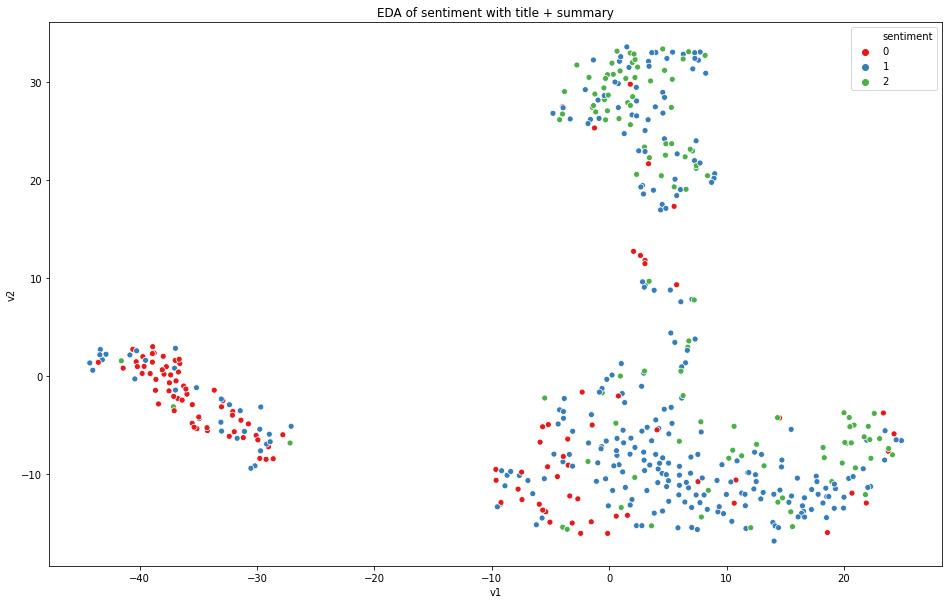

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
def creat_plotting_data(data, labels):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["sentiment"] = labels.to_numpy()
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df


plotting_data_embedded = creat_plotting_data(X_for_graph, labels = y1[:500])
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="sentiment", data=plotting_data_embedded, palette="Set1")
ax.set(title = 'EDA of sentiment with title + summary')
plt.show()

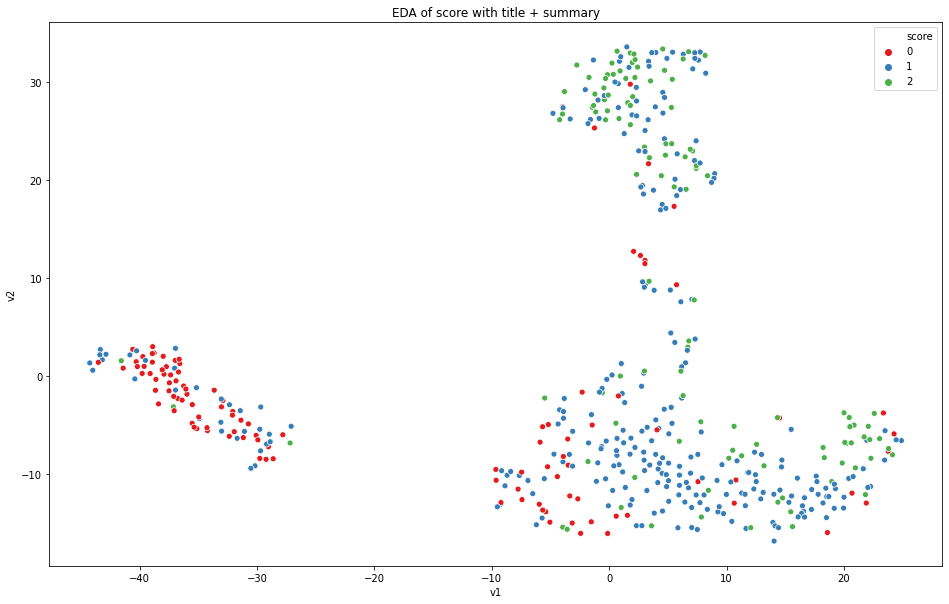

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
def creat_plotting_data(data, labels):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["score"] = labels.to_numpy()
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df


plotting_data_embedded = creat_plotting_data(X_for_graph, labels = y1[:500])
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="score", data=plotting_data_embedded, palette="Set1")
ax.set(title = 'EDA of score with title + summary')
plt.show()

## 3.4 Fine Tuning Functions

Despite the fact that embedding from finBERT seems to be better by the visualization above, the mean validation accuracy and loss from the 5-fold cv with the same data are worse than those of BERT model with a linear classifier. Hence, instead of using the finBERT's classifier, we will just use its embedding and add different linear classifier and check whether the performance gets better or not.


In [53]:
from torch import nn

class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
  def forward(self, x):
    return x
    
class finBertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(finBertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 100, 3

        # Instantiate BERT model
        self.finbert = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
        
        self.finbert.classifier = Identity()
        self.finbert.dropout = Identity() #will not use dropout (on top of pooling layer)

        # Instantiate an one-layer feed-forward classifier
        self.classifier1 = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.finbert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.finbert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0]

        # Feed input to classifier to compute logits
        logits = self.classifier1(last_hidden_state_cls)

        return logits

In [54]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    # Instantiate Bert Classifier
    #finbert_classifier = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
    finbert_classifier = finBertClassifier(freeze_bert = False)


    # Tell PyTorch to run the model on GPU
    finbert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(finbert_classifier.parameters(),
                      lr=2e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return finbert_classifier, optimizer, scheduler

In [57]:
import random
import time
from torch import nn

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    return float(val_loss), float(val_accuracy)
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

## 3.5 Fine Tuning

In [58]:
from sklearn.model_selection import KFold
#train and val are indices
kf = KFold(n_splits=5, shuffle = True)

batch_size = 16
train_loss = []
val_loss = []
val_accuracy = []

y1 = y1.astype(int)

for train_index, val_index in kf.split(X):
  #Data Preparation
  X_train = X[train_index]
  X_val = X[val_index]
  y1_train = y1[train_index]
  y1_val = y1[val_index]
  
  train_inputs, train_masks = preprocessing_for_finbert(X_train)
  val_inputs, val_masks = preprocessing_for_finbert(X_val)
  train_labels = torch.tensor(y1_train.values)
  val_labels = torch.tensor(y1_val.values)
  
  #Data Loader Class
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

  val_data = TensorDataset(val_inputs, val_masks, val_labels)
  val_sampler = RandomSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

  #Fine Tune and Evaluation
  set_seed(42)    # Set seed for reproducibility
  finbert_classifier, optimizer, scheduler = initialize_model(epochs=2)
  val_loss1, val_accuracy1 = train(finbert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)
  
  val_loss.append(val_loss1)
  val_accuracy.append(val_accuracy1)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.982668   |     -      |     -     |   15.16  
   1    |   40    |   0.851193   |     -      |     -     |   15.01  
   1    |   60    |   0.842028   |     -      |     -     |   14.95  
   1    |   69    |   0.736442   |     -      |     -     |   6.13   
----------------------------------------------------------------------
   1    |    -    |   0.873263   |  0.745000  |   68.63   |   55.78  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.635711   |     -      |     -     |   15.02  
   2    |   40    |   0.667003   |     -      |     -     |   14.25  
   2    |   60    |   0.653071   |     -      |     -     |   14.

In [59]:
print('The mean validation accuracy of 5-fold cv is: ',np.mean(val_accuracy))
print('The mean validation loss of 5-fold cv is: ', np.mean(val_loss))

The mean validation accuracy of 5-fold cv is:  71.72685185185185
The mean validation loss of 5-fold cv is:  0.7064891835053763


## 3.6 Confusion matrix and critical error



In [60]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [62]:
probs = bert_predict(finbert_classifier, val_dataloader)

In [63]:
critical_error = 0
crit_error_index = []
for i in range(len(probs)):
  pred = np.argmax(probs[i])
  if abs(pred - y1_val.values[i]) == 2:
    critical_error += 1
    crit_error_index.append(i)

print('The critical error is : ',critical_error/len(probs))

The critical error is :  0.10469314079422383


In [64]:
y_pred = []
for i in range(len(probs)):
  y_pred.append(np.argmax(probs[i]))

from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y1_val.values)

array([[19, 35, 17],
       [27, 65, 25],
       [12, 50, 27]])

# Convolutional Layer instead of Linear Layer

Even though the EDA implies that finBERT embedding should be better on the classification purpose, but the mean cv score shows that BERT embedding is actually better on the classification. Now I will try to put more complicated layers on top of the BERT embedding for the text classification. The original idea is from Yoon Kim's [article](https://arxiv.org/abs/1408.5882) and I have referred to the [tds article](https://towardsdatascience.com/identifying-hate-speech-with-bert-and-cnn-b7aa2cddd60d) for the code implementation. Moreover, for deciding the hyperparameters, I have referred to [Ye Zhang et al](https://arxiv.org/abs/1510.03820).

## 4.1-3 Tokenization to Text data preparation for BERT

Since I will use the BERT embedding for the following neural network, I will use the same code written above

## 4.4 Fine Tuning Functions


In [65]:
from torch import nn
class BERT_KimCNN(nn.Module):
  def __init__(self, embed_max_len, embed_dim, class_num, kernel_num, kernel_size, dropout, static, freeze_bert = False):
    super(BERT_KimCNN, self).__init__()
    '''
    embed_max_len: the max length of embedded vector
    embed_dim: the output dimension of word vector (for BERT, 768)
    class_num: the number of classes in the target
    Co: number of filters to be applied
    
    Ks: the list of filter region sizes (will use [2,3,4])
    '''
    V = embed_max_len
    D = embed_dim
    C = class_num
    Co = kernel_num
    Ks = kernel_size

    self.bert = BertModel.from_pretrained('bert-base-uncased')

    self.static = static
    #Embedding for the convolutional layer
    self.embed = nn.Embedding(V, D)
    #Create 2D convolution for each filters
    self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K,D)) for K in Ks])
    self.dropout = nn.Dropout(dropout)
    self.fc1 = nn.Linear(len(Ks) * Co, C)
    #softmax function 
    self.sigmoid = nn.Sigmoid()

    #Freeze the bert model
    if freeze_bert:
      for param in self.bert.parameters():
        param.requires_grad = False

  def forward(self, input_ids, attention_mask):
    #Feed inputs to BERT
    outputs = self.bert(input_ids = input_ids, 
                        attention_mask = attention_mask)
    
    # Extract the embedded word vectors for the convolutional layer
    x = outputs[0]

    if self.static:
      x = Variable(x)
    
    x = x.unsqueeze(1)

    x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
    x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
    x = torch.cat(x, 1)
    x = self.dropout(x)  # (N, len(Ks)*Co)
    
    logit = self.fc1(x)  # (N, C)
    
    output = self.sigmoid(logit)
    
    return output

In [67]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    embed_max_len = MAX_LEN
    embed_dim = 768
    class_num = 3
    kernel_num = 2
    kernel_size = [2,3,4]
    dropout = 0.1
    static = True
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    # Instantiate Bert Classifier
    bert_cnn = BERT_KimCNN(embed_max_len= embed_max_len,
                           embed_dim = embed_dim,
                           class_num = class_num,
                           kernel_num = kernel_num,
                           kernel_size = kernel_size,
                           dropout = dropout,
                           static = static,
                           freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_cnn.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_cnn.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_cnn, optimizer, scheduler

In [68]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [69]:
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    return float(val_loss), float(val_accuracy)
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [70]:
from sklearn.model_selection import KFold
#train and val are indices
kf = KFold(n_splits=5, shuffle = True)

batch_size = 16
train_loss = []
val_loss = []
val_accuracy = []

y1 = y2.astype(int)

for train_index, val_index in kf.split(X):
  #Data Preparation
  X_train = X[train_index]
  X_val = X[val_index]
  y1_train = y1[train_index]
  y1_val = y1[val_index]
  
  train_inputs, train_masks = preprocessing_for_bert(X_train)
  val_inputs, val_masks = preprocessing_for_bert(X_val)
  train_labels = torch.tensor(y1_train.values)
  val_labels = torch.tensor(y1_val.values)
  
  #Data Loader Class
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

  val_data = TensorDataset(val_inputs, val_masks, val_labels)
  val_sampler = RandomSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

  #Fine Tune and Evaluation
  set_seed(42)    # Set seed for reproducibility
  bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
  val_loss1, val_accuracy1 = train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)
  
  val_loss.append(val_loss1)
  val_accuracy.append(val_accuracy1)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.106942   |     -      |     -     |   5.53   
   1    |   40    |   1.097631   |     -      |     -     |   5.34   
   1    |   60    |   1.093122   |     -      |     -     |   5.45   
   1    |   69    |   1.095202   |     -      |     -     |   2.32   
----------------------------------------------------------------------
   1    |    -    |   1.098824   |  1.097764  |   39.93   |   23.35  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   1.093838   |     -      |     -     |   5.95   
   2    |   40    |   1.090047   |     -      |     -     |   5.69   
   2    |   60    |   1.093931   |     -      |     -     |   5.6

In [71]:
print('The mean validation accuracy of 5-fold cv is: ',np.mean(val_accuracy))
print('The mean validation loss of 5-fold cv is: ', np.mean(val_loss))

The mean validation accuracy of 5-fold cv is:  44.291666666666664
The mean validation loss of 5-fold cv is:  1.0917222155465018


## 4.6 Confusion matrix and critical error


In [72]:
probs = bert_predict(bert_classifier, val_dataloader)

In [74]:
critical_error = 0
crit_error_index = []
for i in range(len(probs)):
  pred = np.argmax(probs[i])
  if abs(pred - y1_val.values[i]) == 2:
    critical_error += 1
    crit_error_index.append(i)

print('The critical error is : ',critical_error/len(probs))

The critical error is :  0.02527075812274368


In [76]:
y_pred = []
for i in range(len(probs)):
  y_pred.append(np.argmax(probs[i]))

from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y1_val.values)

array([[  0,   0,   0],
       [ 78, 115,  66],
       [  7,   8,   3]])